# 물체 검출 결과 평가 방법 이해하기

1. 주어진 recall값에 대한 precision과 confidence threshold 값을 계산합니다.<br/>
    + 계산한 threshold 값을 이용하여 검출 결과를 출력합니다. (practice 1.ipynb 활용) <br/>    
2. 주어진 confidence threshold 값에서의 precision과 recall값을 구해봅니다.    

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from data import VOC_ROOT, VOCAnnotationTransform, VOCDetection, BaseTransform
import torch.utils.data as data
from utils import Timer
from ssd import build_ssd

import sys
import os
import time
import argparse
import numpy as np
import pickle
import cv2

# %matplotlib inline
from matplotlib import pyplot as plt

import xml.etree.ElementTree as ET

labelmap = (  # always index 0
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor')

annopath = os.path.join(VOC_ROOT, 'VOC2007', 'Annotations', '%s.xml')
imgpath = os.path.join(VOC_ROOT, 'VOC2007', 'JPEGImages', '%s.jpg')
imgsetpath = os.path.join(VOC_ROOT, 'VOC2007', 'ImageSets', 'Main', '{:s}.txt')
YEAR = '2007'
dataset_mean = (104, 117, 123)

if torch.cuda.is_available():    
    torch.set_default_tensor_type('torch.cuda.FloatTensor')    
else:
    torch.set_default_tensor_type('torch.FloatTensor')    

## SSD 모델 및 PASCAL VOC2007 데이터 셋 로드

In [2]:
### load net
num_classes = len(labelmap) + 1      # +1 for background
net = build_ssd('vgg16', 300, 21)    # initialize SSD
# checkpoint = 'weights/ssd300_before_optimize.pth'
# checkpoint = 'weights/ssd300_epoch_001.pth'
checkpoint = 'weights/ssd300_mAP_77.43_v2.pth'
net.load_weights(checkpoint)

net.eval()
print('Finished loading model!')

### load data
set_type = 'test'
dataset = VOCDetection(VOC_ROOT, [('2007', set_type)],
                       BaseTransform(300, dataset_mean),
                       VOCAnnotationTransform())

if torch.cuda.is_available():
    net = net.cuda()
    cudnn.benchmark = True

Loading weights into state dict...
Finished!
Finished loading model!


## 물체 검출 수행
Practice 1과 같이 물체 검출을 모든 테스트 셋에 속하는 영상에 대하여 수행합니다.

In [8]:
save_folder = os.path.basename(checkpoint)

from layers import Detect

num_images = len(dataset)
parser = Detect(num_classes, 0, 200, 0.1, 0.45)
softmax = nn.Softmax(dim=-1)

# all detections are collected into:
#    all_boxes[cls] = N x 6 array of detections in
#    (x1, y1, x2, y2, score, ids)
all_boxes =[np.zeros((0,6)) for _ in range(len(labelmap)+1)]

# timers
_t = {'forward': Timer(), 'misc': Timer()}    
        
output_dir = os.path.join(save_folder, set_type)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
det_file = os.path.join(output_dir, 'detections.pkl')

if not os.path.exists(det_file):
    for i in range(num_images):    
        im, gt, h, w, ids = dataset.pull_item_with_index(i)

        x = im.unsqueeze(0)
        if torch.cuda.is_available():
            x = x.cuda()

        _t['forward'].tic()
        with torch.no_grad():    
            loc_pred, cls_pred, priors = net(x)            
        forward_time = _t['forward'].toc(average=True)    

        _t['misc'].tic()
        detections = parser(loc_pred, softmax(cls_pred), priors.type(type(x)))                
                
        # skip j = 0, because it's the background class
        for j in range(1, detections.size(1)):
            dets = detections[0, j, :]    # detections for j-th target class                        
            mask = dets[:, 0].gt(0.).expand(5, dets.size(0)).t()
            dets = torch.masked_select(dets, mask).view(-1, 5)
            if dets.shape[0] == 0:
                continue
            boxes = dets[:, 1:]
            boxes[:, 0] *= w    # because, box coordinates were normalized to [0,1]
            boxes[:, 2] *= w
            boxes[:, 1] *= h
            boxes[:, 3] *= h
            scores = dets[:, 0].cpu().numpy()

            ids_dets = ids*np.ones( (len(scores),1) )    # store image index for evaluation
            cls_dets = np.hstack(    # cls_dets: M x 6 matrix [[x,y,w,h,score,img_idx]]
                (boxes.cpu().numpy(),\
                 scores[:, np.newaxis], \
                 ids_dets
                )).astype(np.float32, copy=False)                
            all_boxes[j] = np.vstack( (all_boxes[j], cls_dets) )
            
        misc_time = _t['misc'].toc(average=True)
        
        if i % 100 == 0:
            print('[im_detect: {:d}/{:d}] forward: {:.3f}s, misc: {:.3f}s'.format(i+1, num_images, forward_time, misc_time))
            
    with open(det_file, 'wb') as f:
        pickle.dump(all_boxes, f, pickle.HIGHEST_PROTOCOL)    
        
    print('Saved to {:}.'.format(det_file))
else:
    with open(det_file, 'rb') as f:
        all_boxes = pickle.load(f)    
    print('Load from {:}.'.format(det_file))    

[im_detect: 1/4952] forward: 0.007s, misc: 0.018s
[im_detect: 101/4952] forward: 0.008s, misc: 0.020s
[im_detect: 201/4952] forward: 0.007s, misc: 0.020s
[im_detect: 301/4952] forward: 0.007s, misc: 0.019s
[im_detect: 401/4952] forward: 0.007s, misc: 0.020s
[im_detect: 501/4952] forward: 0.007s, misc: 0.019s
[im_detect: 601/4952] forward: 0.007s, misc: 0.019s
[im_detect: 701/4952] forward: 0.007s, misc: 0.019s
[im_detect: 801/4952] forward: 0.007s, misc: 0.019s
[im_detect: 901/4952] forward: 0.007s, misc: 0.019s
[im_detect: 1001/4952] forward: 0.007s, misc: 0.019s
[im_detect: 1101/4952] forward: 0.007s, misc: 0.019s
[im_detect: 1201/4952] forward: 0.007s, misc: 0.019s
[im_detect: 1301/4952] forward: 0.007s, misc: 0.019s
[im_detect: 1401/4952] forward: 0.007s, misc: 0.019s
[im_detect: 1501/4952] forward: 0.007s, misc: 0.019s
[im_detect: 1601/4952] forward: 0.007s, misc: 0.019s
[im_detect: 1701/4952] forward: 0.007s, misc: 0.019s
[im_detect: 1801/4952] forward: 0.007s, misc: 0.019s
[im_d

## 정답 데이터(Ground truth) 획득
PASCAL VOC2007 데이터셋에서 제공하는 bounding box 정보들을 로드하기 위한 함수입니다.

In [9]:
def parse_rec(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        obj_struct['pose'] = obj.find('pose').text
        obj_struct['truncated'] = int(obj.find('truncated').text)
        obj_struct['difficult'] = int(obj.find('difficult').text)
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(bbox.find('xmin').text) - 1,
                              int(bbox.find('ymin').text) - 1,
                              int(bbox.find('xmax').text) - 1,
                              int(bbox.find('ymax').text) - 1]
        objects.append(obj_struct)

    return objects

## 검출 성능 평가 함수
주어진 클래스(classname)에 대해서 성능을 평가하는 함수입니다.
parse_rec 함수를 이용하여 정답 데이터를 로드하고, 
검출된 결과들이 있다면(det_boxes) 다음과 같이 성능을 평가합니다.

    0. 검출 결과를 confidence score순으로 정렬합니다.
    1. 높은 confidence를 가지는 검출 결과부터 시작하여, 해당 검출 결과가 발생한 영상의 정답(GT)들과 IoU를 계산합니다.
    2. 가장 높은 IoU가 thershold 이상이라면 TP, 그렇지 않으면 FP 등으로 표시합니다.
    3. 계산된 TP와 FP, npos(TP+FN)를 이용하여 precision과 recall을 계산합니다.
    
+ [TODO] 아래 cell에서 주어지는 given_recall 값에 해당하는 precision 및 confidence score 계산을 위해서 필요한 부분을 수정하세요.
    Hint: 함수를 이용하여 특정 결과를 얻어내려면 반환(return)값을 설정해야 합니다.
        1) 주어진 코드를 잘 읽고 어떤 값들을 반환해야 하는지 생각해보세요.
        2) python 함수에서 반환값을 설정할 때 필요한 명령어를 검색해보세요.

In [10]:
def voc_eval(det_boxes, annopath, imagesetfile, classname, cachedir, ovthresh=0.5):    
    # first load gt
    if not os.path.isdir(cachedir):
        os.mkdir(cachedir)
    cachefile = os.path.join(cachedir, 'annots.pkl')
    
    # read list of images
    with open(imagesetfile, 'r') as f:
        lines = f.readlines()
    imagenames = [x.strip() for x in lines]
    
    if not os.path.isfile(cachefile):
        # load annots
        recs = {}
        for i, imagename in enumerate(imagenames):
            recs[imagename] = parse_rec(annopath % (imagename))
            if i % 100 == 0:
                print('Reading annotation for {:d}/{:d}'.format(
                   i + 1, len(imagenames)))
        # save
        print('Saving cached annotations to {:s}'.format(cachefile))
        with open(cachefile, 'wb') as f:
            pickle.dump(recs, f)
    else:
        # load
        with open(cachefile, 'rb') as f:
            recs = pickle.load(f)

    # extract gt objects for this class
    class_recs = {}
    npos = 0
    for imagename in imagenames:
        R = [obj for obj in recs[imagename] if obj['name'] == classname]
        bbox = np.array([x['bbox'] for x in R])
        difficult = np.array([x['difficult'] for x in R]).astype(np.bool)
        det = [False] * len(R)
        npos = npos + sum(~difficult)
        class_recs[imagename] = {'bbox': bbox,
                                 'difficult': difficult,
                                 'det': det}
    
    if len(det_boxes):
        
        BB = det_boxes[:,:4]
        confidence = det_boxes[:,4]
        image_ids = det_boxes[:,5]        

        # sort by confidence
        sorted_ind = np.argsort(-confidence)
        sorted_scores = np.sort(-confidence)
        BB = BB[sorted_ind, :]
        image_ids = [image_ids[x] for x in sorted_ind]

        # go down dets and mark TPs and FPs
        nd = len(image_ids)
        tp = np.zeros(nd)
        fp = np.zeros(nd)
        for d in range(nd):
            R = class_recs['%06d'%int(image_ids[d])]
            bb = BB[d, :].astype(float)
            ovmax = -np.inf
            BBGT = R['bbox'].astype(float)                    
            
            if BBGT.size > 0:
                # compute overlaps
                # intersection
                ixmin = np.maximum(BBGT[:, 0], bb[0])
                iymin = np.maximum(BBGT[:, 1], bb[1])
                ixmax = np.minimum(BBGT[:, 2], bb[2])
                iymax = np.minimum(BBGT[:, 3], bb[3])
                iw = np.maximum(ixmax - ixmin, 0.)
                ih = np.maximum(iymax - iymin, 0.)
                inters = iw * ih
                uni = ((bb[2] - bb[0]) * (bb[3] - bb[1]) +
                       (BBGT[:, 2] - BBGT[:, 0]) *
                       (BBGT[:, 3] - BBGT[:, 1]) - inters)
                overlaps = inters / uni
                ovmax = np.max(overlaps)
                jmax = np.argmax(overlaps)                                            

            if ovmax > ovthresh:
                if not R['difficult'][jmax]:   # if matched GT is difficult, detected box will be ignored.
                    if not R['det'][jmax]:     # check duplicated detection.                                                
                        tp[d] = 1.
                        R['det'][jmax] = 1
                    else:
                        fp[d] = 1.             # if so, detected box will be considered as false positive.
            else:
                fp[d] = 1.                     # if the detected box is not matched to any GT boxes, false positive.

       
        # compute precision recall
        fp = np.cumsum(fp)
        tp = np.cumsum(tp)
        rec = tp / float(npos)
        # avoid divide by zero in case the first detection matches a difficult
        # ground truth
        prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)

        # 11 point metric
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):    # recall thresholds
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.
    else:
        rec = -1.
        prec = -1.
        ap = -1.

    ### [TODO]
    return rec, prec, ap, -sorted_scores

## 성능 평가 수행
위에 주어진 성능 평가 함수 voc_eval을 활용하여 검출 성능을 평가하고, PR curve를 그려봅니다.
    
+ [TODO] 주어진 recall 값에 해당하는 precision과 score 값을 계산하기 위하여 필요한 부분을 수정하거나 새로 작성하세요.
    Hint: 우리는 [1]번 cell에서 numpy라는 library를 사용하겠다고 정의했습니다.
        1) numpy library에서 특정 조건을 만족하는 행렬의 index를 찾아내는 함수를 찾아보세요. (search example: numpy find conditional index)
        2) 1)의 방법으로 찾아낸 index를 어떻게 활용할 것인지 생각해보세요.

Evaluating detections
Given recall: 0.1
##############################
Reading annotation for 1/4952
Reading annotation for 101/4952
Reading annotation for 201/4952
Reading annotation for 301/4952
Reading annotation for 401/4952
Reading annotation for 501/4952
Reading annotation for 601/4952
Reading annotation for 701/4952
Reading annotation for 801/4952
Reading annotation for 901/4952
Reading annotation for 1001/4952
Reading annotation for 1101/4952
Reading annotation for 1201/4952
Reading annotation for 1301/4952
Reading annotation for 1401/4952
Reading annotation for 1501/4952
Reading annotation for 1601/4952
Reading annotation for 1701/4952
Reading annotation for 1801/4952
Reading annotation for 1901/4952
Reading annotation for 2001/4952
Reading annotation for 2101/4952
Reading annotation for 2201/4952
Reading annotation for 2301/4952
Reading annotation for 2401/4952
Reading annotation for 2501/4952
Reading annotation for 2601/4952
Reading annotation for 2701/4952
Reading annotatio

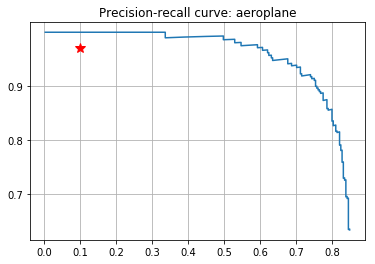


##############################
AP for bicycle = 0.8052
Corresponding precision: 0.9902, confidence score: 0.9337


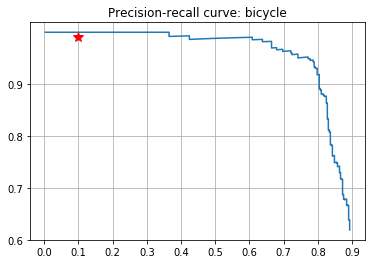


##############################
AP for bird = 0.7570
Corresponding precision: 0.9356, confidence score: 0.7880


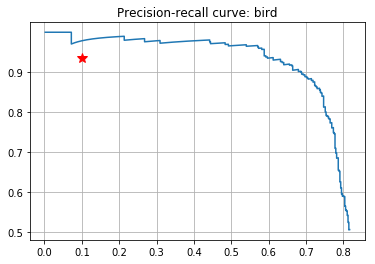


##############################
AP for boat = 0.7014
Corresponding precision: 0.8187, confidence score: 0.6110


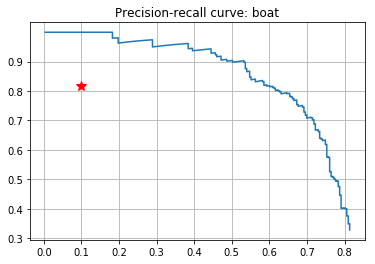


##############################
AP for bottle = 0.4900
Corresponding precision: 0.3686, confidence score: 0.1304


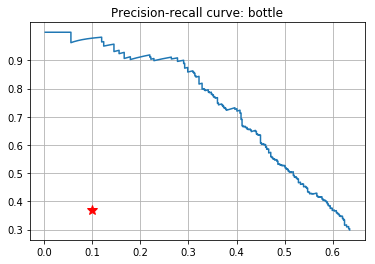


##############################
AP for bus = 0.8479
Corresponding precision: 0.9624, confidence score: 0.9738


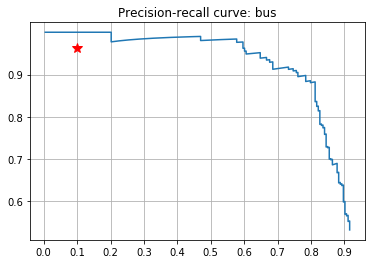


##############################
AP for car = 0.8589
Corresponding precision: 0.9823, confidence score: 0.9463


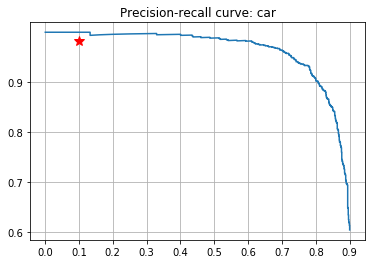


##############################
AP for cat = 0.8736
Corresponding precision: 0.9817, confidence score: 0.9875


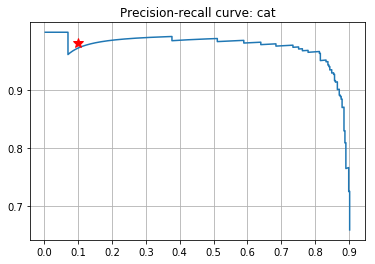


##############################
AP for chair = 0.6028
Corresponding precision: 0.6561, confidence score: 0.3735


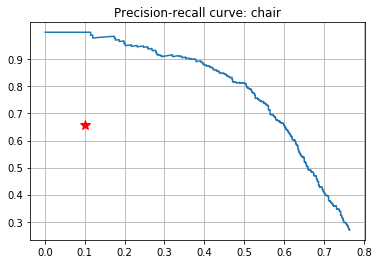


##############################
AP for cow = 0.7776
Corresponding precision: 0.9187, confidence score: 0.7395


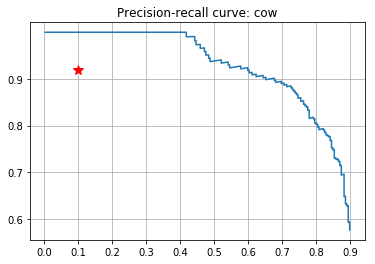


##############################
AP for diningtable = 0.7922
Corresponding precision: 0.8732, confidence score: 0.8310


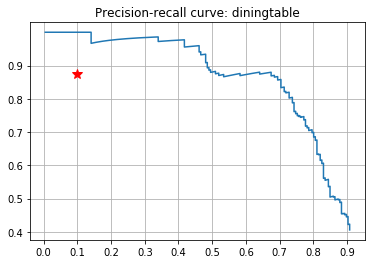


##############################
AP for dog = 0.8558
Corresponding precision: 0.9639, confidence score: 0.9703


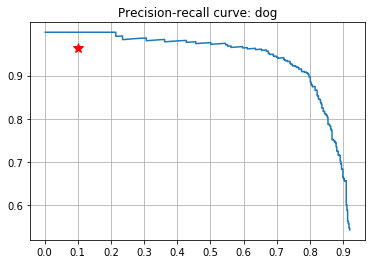


##############################
AP for horse = 0.8709
Corresponding precision: 1.0000, confidence score: 0.9808


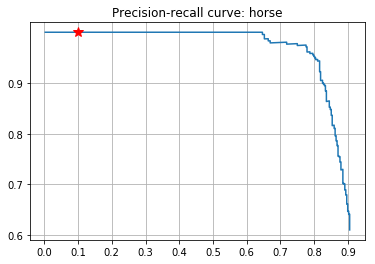


##############################
AP for motorbike = 0.7991
Corresponding precision: 0.9653, confidence score: 0.9426


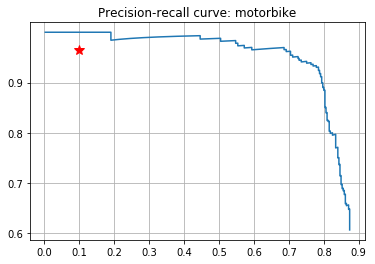


##############################
AP for person = 0.7688
Corresponding precision: 0.9401, confidence score: 0.7393


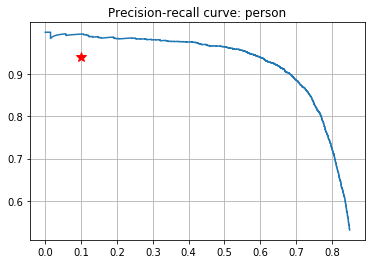


##############################
AP for pottedplant = 0.4862
Corresponding precision: 0.3866, confidence score: 0.1623


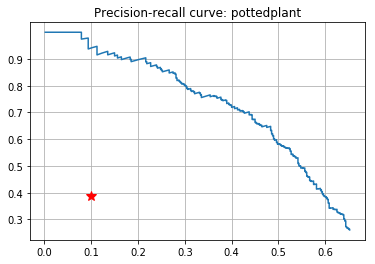


##############################
AP for sheep = 0.7522
Corresponding precision: 0.9481, confidence score: 0.7605


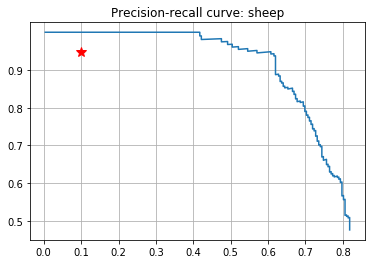


##############################
AP for sofa = 0.7558
Corresponding precision: 0.8944, confidence score: 0.8650


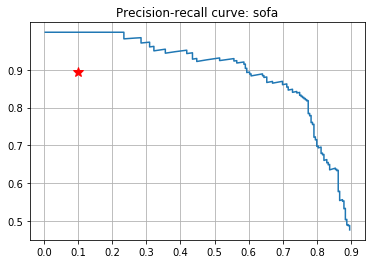


##############################
AP for train = 0.8623
Corresponding precision: 0.9770, confidence score: 0.9872


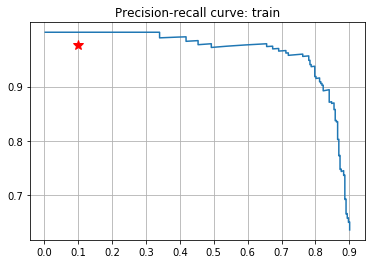


##############################
AP for tvmonitor = 0.7535
Corresponding precision: 0.9113, confidence score: 0.8732


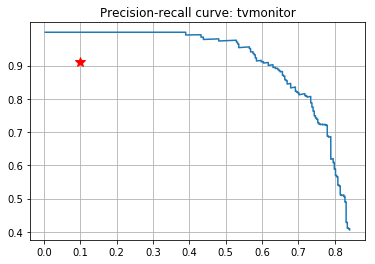


Mean AP = 0.7603


In [11]:
given_recall = 0.1

print('Evaluating detections')
print('Given recall: {}'.format(given_recall))
cachedir = os.path.join(save_folder, 'annotations_cache')
aps = []
for i, cls in enumerate(labelmap):
    
    print('#' * 30)

    ### [TODO]     
    rec, prec, ap, score = voc_eval(all_boxes[i+1], annopath, imgsetpath.format(set_type), cls, cachedir, ovthresh=0.5)
    
    aps += [ap]
    print('AP for {} = {:.4f}'.format(cls, ap))
        
    ### [TODO]
    idx = np.where(rec >= 0.6)[0][0]
    corresponding_prec = prec[idx]
    corresponding_score = score[idx]
        
    print('Corresponding precision: {:.4f}, confidence score: {:.4f}'.format(corresponding_prec, corresponding_score))
        
    # draw PR curve
    fig = plt.figure()
    ax = fig.gca()
    ax.set_xticks(np.arange(0, 1, 0.1))
    ax.set_yticks(np.arange(0, 1., 0.1))
    ax.plot(rec, prec)
    plt.grid()
    plt.title('Precision-recall curve: {:s}'.format(cls))
        
    plt.plot(given_recall, corresponding_prec, color='red', marker='*', markersize=10)
    plt.show()
    print('')
        
print('Mean AP = {:.4f}'.format(np.mean(aps)))

Evaluating detections
Given recall: 0.1
##############################
AP for aeroplane = 0.7953
Corresponding precision: 0.9497, recall: 0.6632


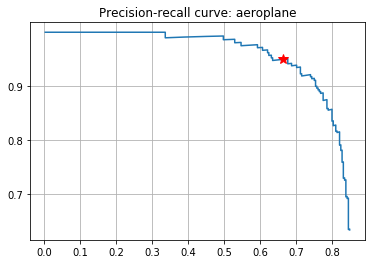


##############################
AP for bicycle = 0.8052
Corresponding precision: 0.9700, recall: 0.6706


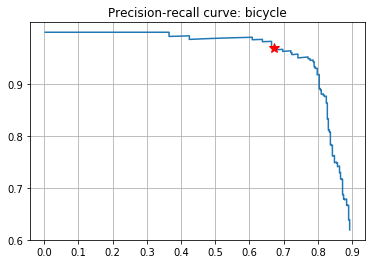


##############################
AP for bird = 0.7570
Corresponding precision: 0.9412, recall: 0.5926


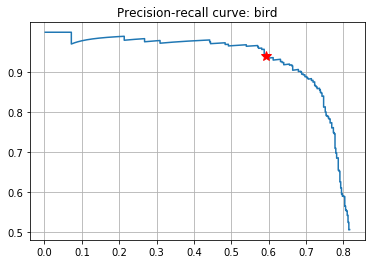


##############################
AP for boat = 0.7014
Corresponding precision: 0.9071, recall: 0.4829


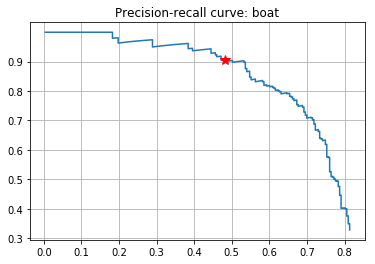


##############################
AP for bottle = 0.4900
Corresponding precision: 0.8992, recall: 0.2281


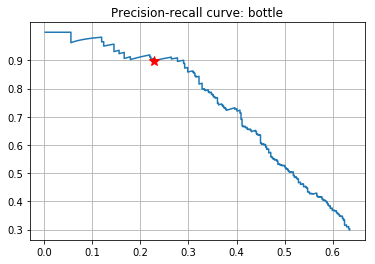


##############################
AP for bus = 0.8479
Corresponding precision: 0.9138, recall: 0.7465


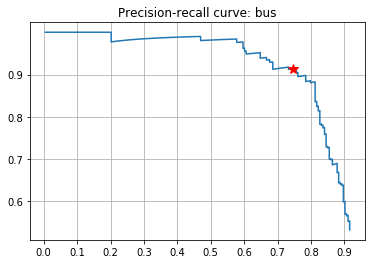


##############################
AP for car = 0.8589
Corresponding precision: 0.9604, recall: 0.7061


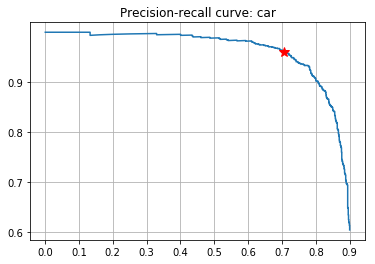


##############################
AP for cat = 0.8736
Corresponding precision: 0.9605, recall: 0.8156


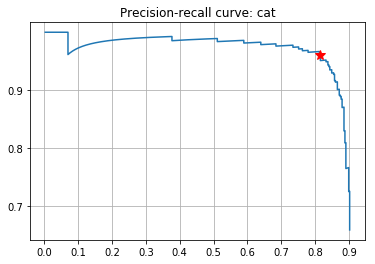


##############################
AP for chair = 0.6028
Corresponding precision: 0.8743, recall: 0.4140


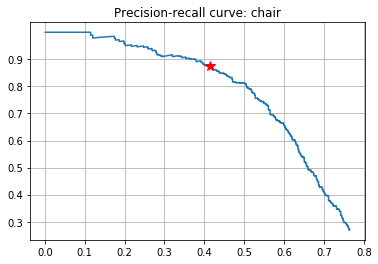


##############################
AP for cow = 0.7776
Corresponding precision: 0.9231, recall: 0.5902


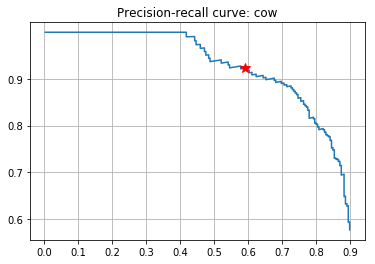


##############################
AP for diningtable = 0.7922
Corresponding precision: 0.8774, recall: 0.6602


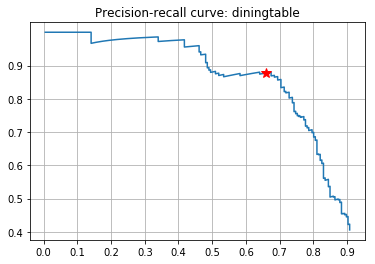


##############################
AP for dog = 0.8558
Corresponding precision: 0.9208, recall: 0.7607


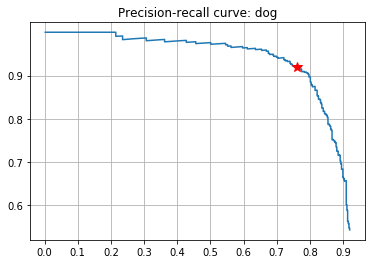


##############################
AP for horse = 0.8709
Corresponding precision: 0.9580, recall: 0.7874


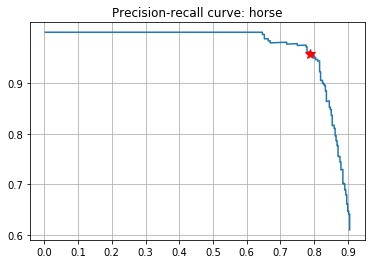


##############################
AP for motorbike = 0.7991
Corresponding precision: 0.9516, recall: 0.7262


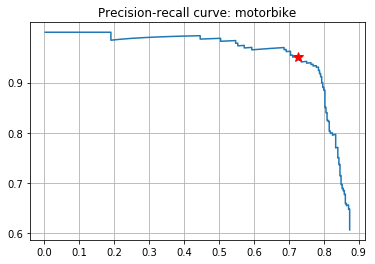


##############################
AP for person = 0.7688
Corresponding precision: 0.9529, recall: 0.5629


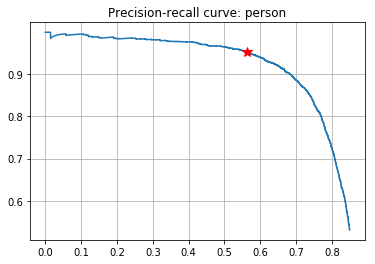


##############################
AP for pottedplant = 0.4862
Corresponding precision: 0.8204, recall: 0.2854


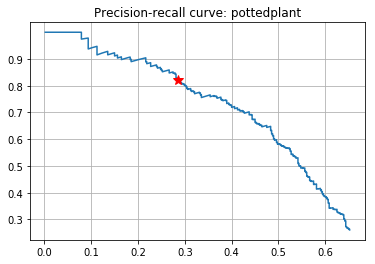


##############################
AP for sheep = 0.7522
Corresponding precision: 0.9452, recall: 0.5702


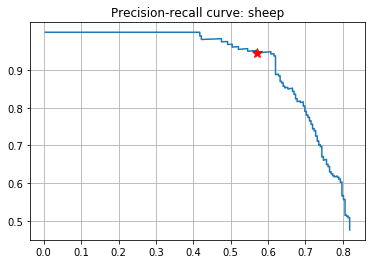


##############################
AP for sofa = 0.7558
Corresponding precision: 0.8844, recall: 0.6402


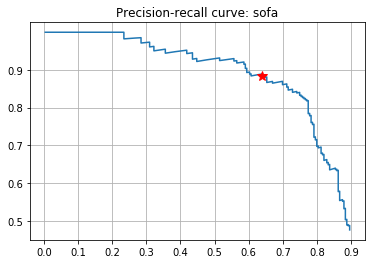


##############################
AP for train = 0.8623
Corresponding precision: 0.9336, recall: 0.7979


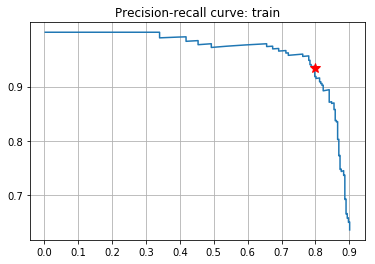


##############################
AP for tvmonitor = 0.7535
Corresponding precision: 0.8909, recall: 0.6364


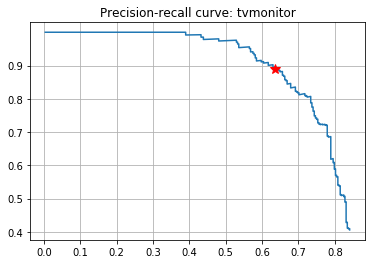


Mean AP = 0.7603


In [12]:
given_threshold = 0.8

print('Evaluating detections')
print('Given recall: {}'.format(given_recall))
cachedir = os.path.join(save_folder, 'annotations_cache')
aps = []
for i, cls in enumerate(labelmap):
    
    print('#' * 30)

    ### [TODO] 
    rec, prec, ap, score = voc_eval(all_boxes[i+1], annopath, imgsetpath.format(set_type), cls, cachedir, ovthresh=0.5)

    
    aps += [ap]
    print('AP for {} = {:.4f}'.format(cls, ap))
        
    ### [TODO]
    idx = np.where(score <= given_threshold)[0][0]
    corresponding_prec = prec[idx]
    corresponding_rec = rec[idx]
        
    print('Corresponding precision: {:.4f}, recall: {:.4f}'.format(corresponding_prec, corresponding_rec))
        
    # draw PR curve
    fig = plt.figure()
    ax = fig.gca()
    ax.set_xticks(np.arange(0, 1, 0.1))
    ax.set_yticks(np.arange(0, 1., 0.1))
    ax.plot(rec, prec)
    plt.grid()
    plt.title('Precision-recall curve: {:s}'.format(cls))                
        
    plt.plot(corresponding_rec, corresponding_prec, color='red', marker='*', markersize=10)        
    plt.show()
    
    print('')
        
    
print('Mean AP = {:.4f}'.format(np.mean(aps)))